Notebook from Ayushman Buragohain

## resnext50_32x4d + MixUp + Label-Smoothing + Ranger + Flat-Anneal + Mish

In [1]:
import os
import wandb
import albumentations as A
import timm

from fastai.vision.all import *
from fastai.callback.wandb import *

from cassava_utils import *

In [2]:
SEED        = 42
IDX         = generate_random_id()
OOF_FOLD    = 0
NUM_CLASSES = 5
CSV_PATH    = '../data/fold_df.csv'
IMAGE_DIR   = '../../train_images/'
INPUT_DIMS  = 224
MODEL       = 'resnext50_32x4d'
PROJECT     = 'kaggle-leaf-disease-fastai-runs'
SAVE_NAME   = f"{MODEL}-fold={OOF_FOLD}-{IDX}"

set_seed(SEED, reproducible=True)

Ts = [MODEL, 'ranger', 'label-smoothing', 'mish', str(INPUT_DIMS) + 'mixup']
Ns = f'{MODEL} + Mish + Ranger + LabelSmoothing + MixUp'
run = wandb.init(project=PROJECT, tags=Ts, notes=Ns,)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /home/qblocks/.netrc


In [3]:
data = get_dataset(CSV_PATH, IMAGE_DIR, OOF_FOLD, shuffle=True)
data.head()

,image_id,label,filePath,kfold,is_valid
0,1587173996.jpg,Healthy,../../train_images/1587173996.jpg,2,False
1,404115232.jpg,Cassava Mosaic Disease (CMD),../../train_images/404115232.jpg,0,True
2,3945098769.jpg,Cassava Mosaic Disease (CMD),../../train_images/3945098769.jpg,1,False
3,4037735151.jpg,Cassava Mosaic Disease (CMD),../../train_images/4037735151.jpg,3,False
4,730805822.jpg,Cassava Mosaic Disease (CMD),../../train_images/730805822.jpg,1,False


In [6]:
TRAIN_AUGS = A.Compose([
    A.OneOf([A.RandomResizedCrop(INPUT_DIMS, INPUT_DIMS), A.CenterCrop(INPUT_DIMS, INPUT_DIMS)], p=0.5),
    A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0),
    A.HorizontalFlip(),
    A.OneOf([A.Rotate(), A.VerticalFlip()], p=0.5),
    A.OneOf([A.Flip(), A.IAAPerspective(), A.ShiftScaleRotate()], p=0.5),
    A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    A.OneOf([A.CLAHE(), A.HueSaturationValue(0.2, 0.2, 0.2), A.IAASharpen()], p=0.5),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5, num_holes=15),
])

VALID_AUGS = A.Compose([A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0)])

ITEM_TFMS  = AlbumentationsTransform(TRAIN_AUGS, VALID_AUGS)
BATCH_TFMS = [Normalize.from_stats(*imagenet_stats)]

n_gpus = num_distrib() or 1

cassava = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  splitter=ColSplitter(),
                  get_x=lambda o: o['filePath'], 
                  get_y=lambda o: o['label'], 
                  item_tfms=ITEM_TFMS, 
                  batch_tfms=BATCH_TFMS)

dls = cassava.dataloaders(data, bs=32)

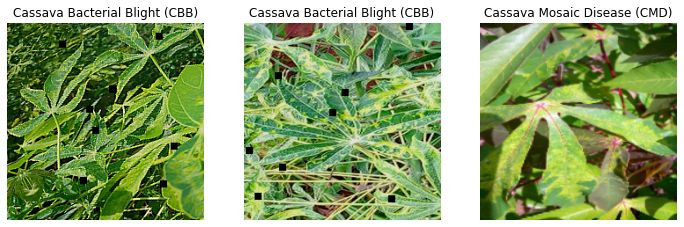

In [7]:
dls.train.show_batch(max_n=3,figsize=(12,6))

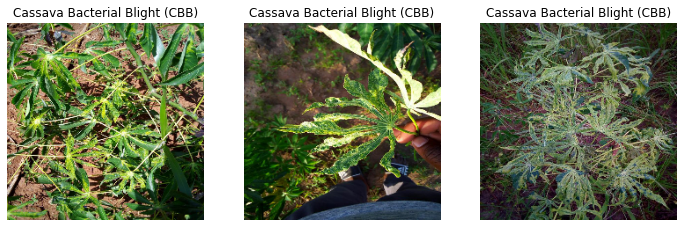

In [8]:
dls.valid.show_batch(max_n=3,figsize=(12,6))

In [9]:
class Mish(nn.Module):
    def __init__(self)  : super().__init__()
    def forward(self, x): return x *( torch.tanh(F.softplus(x)))

def mod_acts(model, func, activs:list = [nn.ReLU, nn.SiLU]):
    'recursively replace all the `activs` with `func`'
    for child_name, child in model.named_children():
        for act in activs:
            if isinstance(child, act):
                setattr(model, child_name, func)
        else:
            mod_acts(child, func)
            
@delegates(Learner)
def timm_learner(dls,m_name:str, cut:int, c:int, state:str=None, init:bool=True, 
                pretrained:bool=True, act:callable=nn.ReLU(inplace=True), modifier=None, **kwargs):
    'create a fast.ai learner instance from timm'
    encoder = timm.create_model(m_name, pretrained=pretrained, )
    
    model   = TransferLearningModel(encoder, num_classes=c, cut=cut, act=act, init=init)
    
    if modifier is not None: modifier(model)
    if state is not None   : model.load_state_dict(torch.load(state)) 
    
    learn = Learner(dls, model, **kwargs)
    return learn

In [10]:
learn = timm_learner(dls, MODEL, cut=-2, c=dls.c, pretrained=True, act=Mish(),
                    metrics=[accuracy], splitter=custom_splitter, 
                    modifier=partial(mod_acts, func=Mish()), init=True,
                    opt_func=ranger, loss_func=LabelSmoothingCrossEntropy(),
                    cbs=[WandbCallback(seed=SEED, log_preds=False, log_model=False)]).to_native_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50_32x4d_ra-d733960d.pth" to /home/qblocks/.cache/torch/hub/checkpoints/resnext50_32x4d_ra-d733960d.pth


SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=1.5848931980144698e-06)

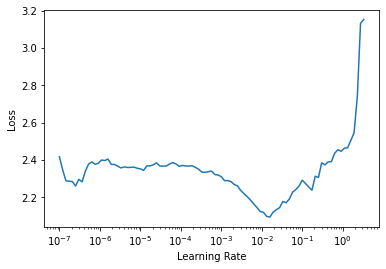

In [13]:
learn.lr_find()

In [ ]:
learn.freeze()
learn.fit_flat_cos(2, 2e-03, wd=0.3, cbs=[MixUp(), GradientAccumulation(n_acc=4*dls.bs)])

epoch,train_loss,valid_loss,accuracy,time
0,1.254879,1.068309,0.666121,04:51


In [ ]:
save_dir = f"../../{SAVE_NAME}.pt"
torch.save(learn.model.state_dict(), save_dir)

In [ ]:
wandb.save(save_dir); wandb.finish()